In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Othercomputers/'My MacBook Pro'/GCode/WP_cryoEM

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/GCode/WP_cryoEM


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%cd /content/drive/Othercomputers/'My MacBook Pro'/GCode/WP_cryoEM
from utils import *
from skimage.data import shepp_logan_phantom
from skimage.transform import  rescale, radon, iradon
from skimage.morphology import disk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import kneighbors_graph
from model import MLP
import torch


#####################
n_neighbors=8
MIN_ANGLE=0
MAX_ANGLE = 360
SAMPLES = 1024
SIGNAL_SIZE = 512
directed = False
SNR=12
#####################
walk_len=4
val_ratio=0.05
batch_size=256
lr=0.01
weight_decay=0.0005
#####################


In [ ]:
theta_list = np.linspace(MIN_ANGLE, MAX_ANGLE, SAMPLES)


parentPhantom = shepp_logan_phantom()
scale = SIGNAL_SIZE/ parentPhantom.shape[1]
parentPhantom = rescale(parentPhantom, scale=scale, mode='reflect')
#phantomDisk = disk(SIGNAL_SIZE/2)[1:,1:]
#parentPhantom=parentPhantom*phantomDisk
print('#Creating sinogram#')
sinogram =radon(parentPhantom, theta=theta_list,circle=True)



sinogram_noise=add_noise(SNR,sinogram)

#Creating sinogram#


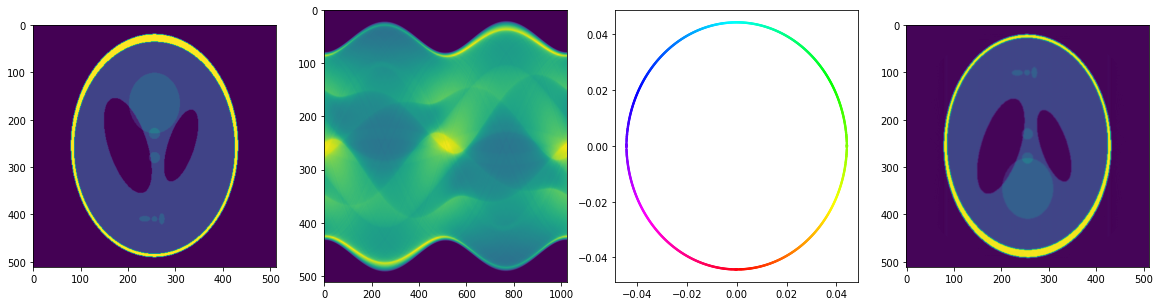

In [ ]:
fig, (ax0,ax1, ax2, ax3) = plt.subplots(1, 4,figsize=(20,5))
ax0.imshow(parentPhantom)
e1,e2=compute_Laplacian(sinogram,n_neighbors=n_neighbors)
ax1.imshow(sinogram,aspect='auto')
ax2.scatter(e1,e2,c=theta_list/360,cmap='hsv',s=2)

theta_L=np.arctan2(e1, e2)
theta_L_sort=np.argsort(theta_L)
theta_recovered=theta_list[theta_L_sort]

parentPhantom_recovered =iradon(sinogram,theta=theta_recovered, filter_name='hamming',interpolation='cubic')
ax3.imshow(parentPhantom_recovered)

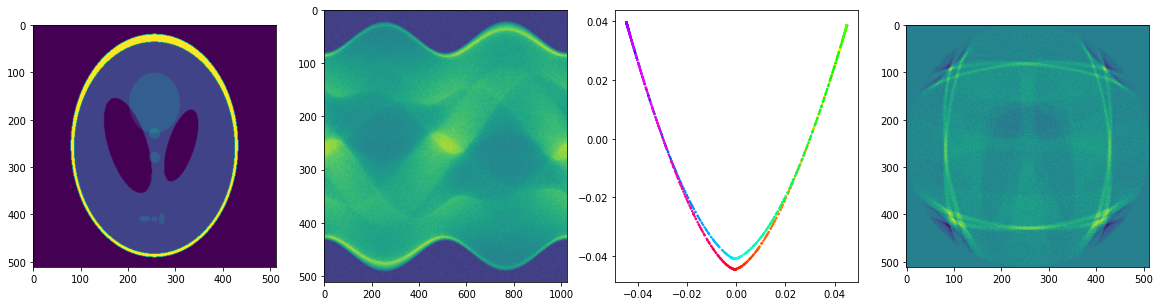

In [ ]:
fig, (ax0,ax1, ax2, ax3) = plt.subplots(1, 4,figsize=(20,5))
ax0.imshow(parentPhantom)
sinogram_noise=add_noise(SNR,sinogram)


ax1.imshow(sinogram_noise,aspect='auto')




e1,e2=compute_Laplacian(sinogram_noise,n_neighbors=n_neighbors)

ax2.scatter(e1,e2,c=theta_list/360,cmap='hsv',s=2)

theta_L=np.arctan2(e1, e2)
theta_L_sort=np.argsort(theta_L)
theta_recovered=theta_list[theta_L_sort]

parentPhantom_recovered =iradon(sinogram_noise,theta=theta_recovered, filter_name='hamming',interpolation='cubic')
ax3.imshow(parentPhantom_recovered)

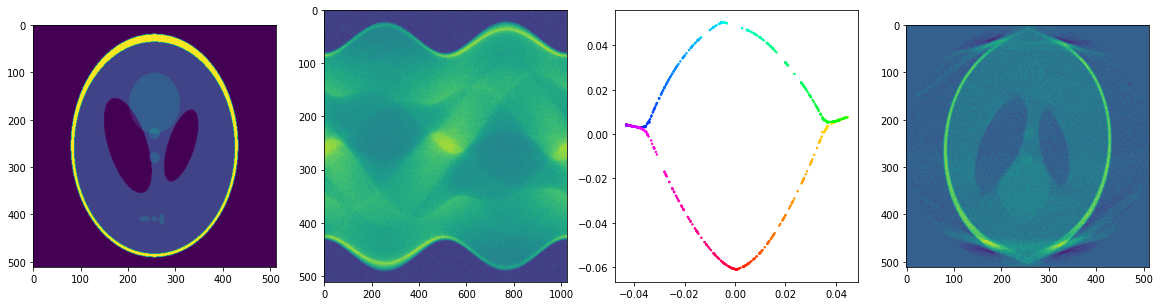

In [ ]:

print('#Walkpooling#')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('##prepare_train_dataset##')
train_loader,val_loader=prepare_train_dataset(sinogram,n_neighbors,walk_len,batch_size,val_ratio,directed)


model=MLP(2*walk_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

def train(loader,epoch):
    model.train()
    loss_epoch=0
    for data in tqdm(loader):  # Iterate in batches over the training dataset.
        input = data['data'].to(device)
        label = data['label'].to(device)
        out = model(input)
        loss = criterion(out.view(-1), label)  
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()
        loss_epoch=loss_epoch+loss.item()
    return loss_epoch/len(loader)

def test(loader):
    model.eval()
    loss_epoch=0
    scores = torch.tensor([]).to(device)
    labels = torch.tensor([])
    for data in tqdm(loader):  # Iterate in batches over the training dataset.
        input = data['data'].to(device)
        label = data['label'].to(device)
        out = model(input)
        scores = torch.cat((scores,out),dim = 0)
        labels = torch.cat((labels,label.view(-1,1).cpu().clone().detach()),dim = 0)
    scores_np = scores.cpu().clone().detach().numpy()
    labels = labels.cpu().clone().detach().numpy()
    return scores_np.reshape(-1) ,roc_auc_score(labels, scores_np)
print('##training##')
for epoch in range(10):
    loss_epoch = train(train_loader,epoch)
    scores,AUC=test(val_loader)
    print('epoch:',epoch, ' AUC:',AUC)

#Walkpooling#
##prepare_train_dataset##


100%|██████████| 8264/8264 [00:23<00:00, 344.80it/s]


##training##


100%|██████████| 2/2 [00:00<00:00, 256.46it/s]


epoch: 0  AUC: 0.9956850053937432


100%|██████████| 2/2 [00:00<00:00, 264.92it/s]


epoch: 1  AUC: 0.9975610900051592


100%|██████████| 2/2 [00:00<00:00, 216.48it/s]


epoch: 2  AUC: 0.9988508981755077


100%|██████████| 2/2 [00:00<00:00, 237.95it/s]


epoch: 3  AUC: 0.9974907368322311


100%|██████████| 2/2 [00:00<00:00, 234.87it/s]


epoch: 4  AUC: 0.998827447117865


100%|██████████| 2/2 [00:00<00:00, 253.12it/s]


epoch: 5  AUC: 0.9987570939449368


100%|██████████| 2/2 [00:00<00:00, 282.65it/s]


epoch: 6  AUC: 0.999530978847146


100%|██████████| 2/2 [00:00<00:00, 211.31it/s]


epoch: 7  AUC: 0.9994371746165751


100%|██████████| 2/2 [00:00<00:00, 238.30it/s]


epoch: 8  AUC: 0.998827447117865


100%|██████████| 2/2 [00:00<00:00, 253.63it/s]

epoch: 9  AUC: 0.9988508981755077


##reconnect##


100%|██████████| 39/39 [00:00<00:00, 295.40it/s]


##Plotting##


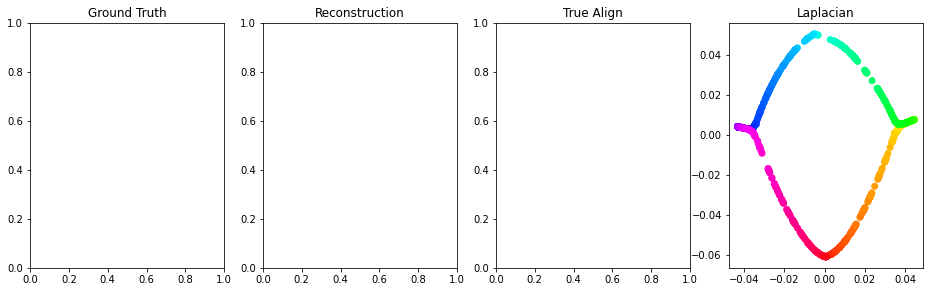

In [ ]:

print('##reconnect##')
A=None
for i in range(-1,0):
    test_loader,edge_index=prepare_test_dataset(sinogram_noise,A,n_neighbors,walk_len,batch_size,SAMPLES,i,directed)
    scores,AUC=test(test_loader)
    A=update_A(edge_index,scores,SAMPLES,n_neighbors,directed)
    e1,e2=compute_Laplacian(A,n_neighbors = n_neighbors,precomputed=True)
    print('##Plotting##')
    # theta_L=np.arctan2(e1, e2)
    # theta_L_sort=np.argsort(theta_L)
    # theta_recovered=theta_list[theta_L_sort]
    # parentPhantom_recovered =iradon_re(sinogram_noise,theta_recovered)
    # parentPhantom_recovered_true_shift =iradon_re(sinogram_noise,theta_list)


    imkwargs = dict(vmin=0, vmax=1)
    fig, (ax0,ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 4.5),
                                   sharex=False, sharey=False)
    ax0.set_title('Ground Truth')
    ax1.set_title('Reconstruction')
    ax2.set_title('True Align')
    ax3.set_title('Laplacian')

    # ax0.imshow(parentPhantom, cmap=plt.cm.Greys_r,**imkwargs)

    # ax1.imshow(parentPhantom_recovered, cmap=plt.cm.Greys_r,**imkwargs)
    # ax2.imshow(parentPhantom_recovered_true_shift, cmap=plt.cm.Greys_r)
    ax3.scatter(e1, e2,c=theta_list/360,cmap='hsv')
    #plt.savefig('L'+str(i)+'.png')
    plt.show()


In [ ]:
fig, (ax0,ax1, ax2, ax3) = plt.subplots(1, 4,figsize=(20,5))
ax0.imshow(parentPhantom)



ax1.imshow(sinogram_noise,aspect='auto')
ax2.scatter(e1,e2,c=theta_list/360,cmap='hsv',s=2)

theta_L=np.arctan2(e1, e2)
theta_L_sort=np.argsort(theta_L)
theta_recovered=theta_list[theta_L_sort]

parentPhantom_recovered =iradon(sinogram_noise,theta=theta_recovered, filter_name='hamming',interpolation='cubic')
ax3.imshow(parentPhantom_recovered)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

In [ ]:
theta = np.linspace(0, 2 *np.pi, 30)
w = np.linspace(-0.25, 0.25, 8)
w, theta = np.meshgrid(w, theta)

In [ ]:
phi = 0.5 * theta

In [ ]:
r = 1 + w * np.cos(phi)

x = np.ravel(r * np.cos(theta))
y = np.ravel(r * np.sin(theta))
z = np.ravel(w * np.sin(phi))

In [ ]:
from matplotlib.tri import Triangulation

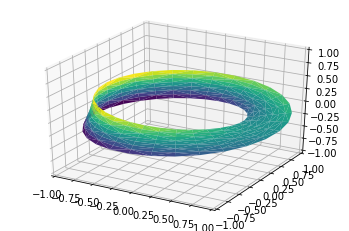

In [ ]:
#triangulate it
tri = Triangulation(np.ravel(w), np.ravel(theta))

ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap='viridis', linewidths=0.2);

ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1);

In [ ]:
data=np.array([x,y,z])

In [ ]:
data

array([[ 7.50000000e-01,  8.21428571e-01,  8.92857143e-01,
         9.64285714e-01,  1.03571429e+00,  1.10714286e+00,
         1.17857143e+00,  1.25000000e+00,  7.33896665e-01,
         8.03246348e-01,  8.72596031e-01,  9.41945714e-01,
         1.01129540e+00,  1.08064508e+00,  1.14999476e+00,
         1.21934445e+00,  6.85986217e-01,  7.49297418e-01,
         8.12608619e-01,  8.75919819e-01,  9.39231020e-01,
         1.00254222e+00,  1.06585342e+00,  1.12916462e+00,
         6.07488036e-01,  6.61375187e-01,  7.15262339e-01,
         7.69149490e-01,  8.23036641e-01,  8.76923793e-01,
         9.30810944e-01,  9.84698095e-01,  5.00498315e-01,
         5.42466306e-01,  5.84434298e-01,  6.26402289e-01,
         6.68370280e-01,  7.10338272e-01,  7.52306263e-01,
         7.94274255e-01,  3.68068657e-01,  3.96737167e-01,
         4.25405676e-01,  4.54074186e-01,  4.82742695e-01,
         5.11411205e-01,  5.40079715e-01,  5.68748224e-01,
         2.14283975e-01,  2.29496650e-01,  2.44709325e-0

In [ ]:
def compute_Laplacian(sinogram,n_neighbors = 10,precomputed=False):
    if not precomputed:
        data=sinogram.T
        A_nl= kneighbors_graph(data, n_neighbors=n_neighbors).toarray()
    else:
        A_nl=sinogram
    A_knn=0.5*(A_nl+A_nl.T)
    L = np.diag(A_knn.sum(axis=1)) - A_knn
    L=sparse.csr_matrix(L)
    eigenValues, eigenVectors=eigsh(L,k=4,which='SM')
    idx = np.argsort(eigenValues)
    return eigenVectors[:, idx[1]],eigenVectors[:, idx[2]],eigenVectors[:, idx[3]]

In [ ]:

e1,e2,e3=compute_Laplacian(data,n_neighbors=n_neighbors)

In [ ]:
plt.scatter3D(e1,e2,e3)

AttributeError: ignored

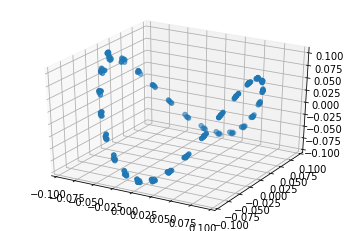

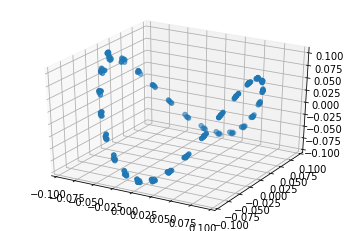

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(e1, e2, e3)
fig

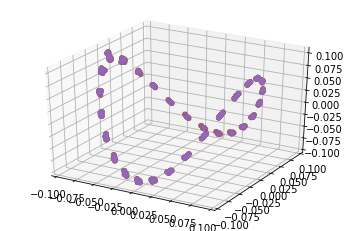